# Classifier with SMOTE technique

## Based on the original Notebook at this link:
https://github.com/Pitsillides91/Python-Tutorials/tree/master/Decision%20Tree%20Tutorials

**Notes:**
* Compared with the original Notebook, the RECALL rate was increased *two* fold after implementing SMOTE.
* Additionally, as it just uses Trees, there is no need to scale/normalise the dataset.
* Confusion matrix uses `sklearn` libraries

## 1. Loading the Packages we need

In [15]:
# Packages / libraries
import os #provides functions for interacting with the operating system
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

# To install sklearn type "pip install numpy scipy scikit-learn" to the anaconda terminal

# To change scientific numbers to float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

# Increases the size of sns plots
sns.set(rc={'figure.figsize':(8,6)})

# Datetime lib
from pandas import to_datetime
import itertools
import warnings
import datetime
warnings.filterwarnings('ignore')

# from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score

# pip install graphviz
# conda install python-graphviz

In [3]:
# pip install graphviz

Note: you may need to restart the kernel to use updated packages.


## 2. Problem Formulation - What are we trying to solve?

We want to predict if a customer will churn or not

### 3.1 Reading / Loading the Raw Data into Python from SQL

In [5]:
#################################################################################################################
##############################   Getting the file from SQL Server      ##########################################
#################################################################################################################

import pypyodbc as podbc

conn2 = podbc.connect("Driver={SQL Server Native Client 11.0};"
                     "Server=DESKTOP-8L98FK0\MSSQLSERVER09;"
                     "Database=Data360YP;"
                     "Trusted_Connection=yes;")

# rynning the SQL quey i need
SQL_Query = pd.read_sql_query('''SELECT * FROM [dbo].[Churn_raw_data]''', conn2)

#conn.close()

# print the shape
print(SQL_Query.shape)

# Viz
SQL_Query.head()

(10000, 14)


,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.8,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### 3.2 Reading / Loading the Raw Data into Python From CSV

In [16]:
#################################################################################################################
################################ Getting the file from local CSV      ###########################################
#################################################################################################################

# Loading the data
# raw_data = pd.read_csv('F:\\Github\Python tutorials\\Decision Trees\\churn raw data.csv', encoding='latin-1')
raw_data = pd.read_csv('churn raw data.csv', encoding='latin-1')

# print the shape
print(raw_data.shape)

#runs the first 5 rows
raw_data.head()

(10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## 4. Data Pre-Processing Phase

In [5]:
# Checking for null values
raw_data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

#### Check for imbalance in the dataset

In [17]:
# Determine the percentage of customers who churned ('Exited' field)

# raw_data['Exited'].value_counts()`
raw_data['Exited'].value_counts(normalize=True) * 100

0    79.63
1    20.37
Name: Exited, dtype: float64

##### As expected in a Churn Prediction model, the dataset is highly imbalanced. More info here:
https://machinelearningmastery.com/what-is-imbalanced-classification/

In [7]:
raw_data.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [35]:
# Limiting the data
raw_data = raw_data[['CreditScore', 'Geography',
                      'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
                      'IsActiveMember', 'EstimatedSalary', 'Exited']]

In [47]:
raw_data.tail()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1
9995,771,39,5,0.00,2,96270.64,0,1,0,0,0,1,0,1,1,0
9996,516,35,10,57369.61,1,101699.77,0,1,0,0,0,1,0,1,0,1
9997,709,36,7,0.00,1,42085.58,1,1,0,0,1,0,1,0,0,1
9998,772,42,3,75075.31,2,92888.52,1,0,1,0,0,1,0,1,1,0
9999,792,28,4,130142.79,1,38190.78,0,1,0,0,1,0,0,1,1,0


In [46]:
# Making categorical variables into numeric representation (aka hot-code encoding)

raw_data = pd.get_dummies(raw_data, columns = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember'])

KeyError: "None of [Index(['Geography', 'Gender', 'HasCrCard', 'IsActiveMember'], dtype='object')] are in the [columns]"

In [48]:
raw_data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1
0,619,42,2,0.00,1,101348.88,1,1,0,0,1,0,0,1,0,1
1,608,41,1,83807.86,1,112542.58,0,0,0,1,1,0,1,0,0,1
2,502,42,8,159660.80,3,113931.57,1,1,0,0,1,0,0,1,1,0
3,699,39,1,0.00,2,93826.63,0,1,0,0,1,0,1,0,1,0
4,850,43,2,125510.82,1,79084.10,0,0,0,1,1,0,0,1,0,1


## 5. Splitting the Raw Data - Hold-out validation

In [49]:
X = raw_data.drop('Exited', axis=1).values # Input features (attributes)
y = raw_data['Exited'].values # Target vector
print('X shape: {}'.format(np.shape(X)))
print('y shape: {}'.format(np.shape(y)))

X shape: (10000, 15)
y shape: (10000,)


In [152]:
X = raw_data.drop('Exited', axis=1) # Input features (attributes)
y = raw_data['Exited'] # Target vector
print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (10000, 15)
y shape: (10000,)


In [54]:
X.tail()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1
9995,771,39,5,0.00,2,96270.64,1,0,0,0,1,0,1,1,0
9996,516,35,10,57369.61,1,101699.77,1,0,0,0,1,0,1,0,1
9997,709,36,7,0.00,1,42085.58,1,0,0,1,0,1,0,0,1
9998,772,42,3,75075.31,2,92888.52,0,1,0,0,1,0,1,1,0
9999,792,28,4,130142.79,1,38190.78,1,0,0,1,0,0,1,1,0


In [55]:
y.tail()

9995    0
9996    0
9997    1
9998    1
9999    0
Name: Exited, dtype: int64

### 5.1 Over-sampling using SMOTE

In [159]:
from collections import Counter
from imblearn.over_sampling import SMOTE

# sampling_strategy = 0.5 ---> 1:2 (1 uncommon per 2 common values)
# imb_model = SMOTE(sampling_strategy=0.5, random_state=123)
imb_model = SMOTE(sampling_strategy=0.75, random_state=123)

X_resampled, y_resampled = imb_model.fit_resample(X, y)

print('Original dataset shape %s' % Counter(y))
print()
print('Resampled dataset shape %s' % Counter(y_resampled))
print('Resampled dataset (normalised):')
print(y_resampled.value_counts(normalize=True) * 100)

Original dataset shape Counter({0: 7963, 1: 2037})

Resampled dataset shape Counter({0: 7963, 1: 5972})
Resampled dataset (normalised):
0    57.143882
1    42.856118
Name: Exited, dtype: float64


In [104]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.9, test_size=0.1, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, train_size = 0.9, test_size=0.1, random_state=0)

## 6. Running Decision Tree

Notes:

- Decision Trees are a supervised learning method used for classification and regression

How it works:
- The ID3 algorithm begins with the original set {S} S as the root node
- On each iteration of the algorithm, it iterates through every unused attribute of the set and calculates the entropy (or information gain) of that attribute
- It then selects the attribute which has the smallest entropy (or largest information gain) value. 
- The set is then split by the selected attribute to produce subsets of the data. 
- The algorithm continues to recurse on each subset, considering only attributes never selected before.

How Decision Tree works best explanation: https://www.youtube.com/watch?v=_XhOdSLlE5c&ab_channel=VictorLavrenko

What is information gain / entropy: https://www.youtube.com/watch?v=nodQ2s0CUbI&ab_channel=VictorLavrenko

Scikit Documentation: https://scikit-learn.org/stable/modules/tree.html

In [105]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=1)
dt.fit(X_train, y_train)

# Doc:https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=1)

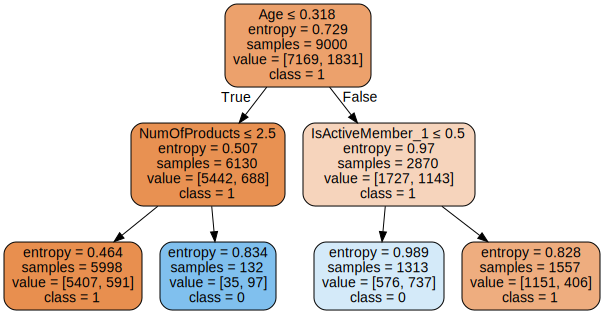

In [18]:
import graphviz 

dot_data = tree.export_graphviz(dt, out_file=None, 
    feature_names=new_raw_data.drop('Exited', axis=1).columns,    
    class_names=new_raw_data['Exited'].unique().astype(str),  
    filled=True, rounded=True,  
    special_characters=True)
graph = graphviz.Source(dot_data)
graph

#### Calculating Feature Importance

In [106]:
feat_impor = pd.DataFrame({'Feature': np.array(raw_data.drop('Exited', axis=1).columns),
                           'Importance': dt.feature_importances_})
feat_impor.sort_values('Importance', ascending=False)

,Feature,Importance
1,Age,0.574769
14,IsActiveMember_1,0.273600
4,NumOfProducts,0.151631
0,CreditScore,0.000000
2,Tenure,0.000000
3,Balance,0.000000
5,EstimatedSalary,0.000000
6,Geography_France,0.000000
7,Geography_Germany,0.000000
8,Geography_Spain,0.000000


In [107]:
# Accuracy on Train
print("Training Accuracy is: %.3f" % dt.score(X_train, y_train))

# Accuracy on Test
print("Testing Accuracy is: ", dt.score(X_test, y_test))

Training Accuracy is: 0.740
Testing Accuracy is:  0.7711621233859397


In [108]:
y_pred = dt.predict(X_test)

#### Calculate Confusion Matrix on TEST dataset

In [109]:
confusion_matrix(y_test, y_pred)

array([[756,  51],
       [268, 319]], dtype=int64)

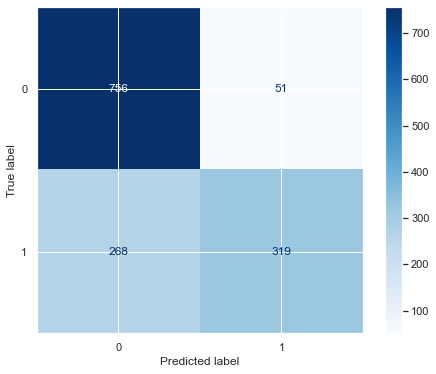

In [110]:
import matplotlib.pyplot as plt  

from sklearn.metrics import plot_confusion_matrix

# plot_confusion_matrix(dt, X_test, y_test,cmap=plt.cm.Blues, values_format='.3f', normalize=('true'))  
plot_confusion_matrix(dt, X_test, y_test, cmap=plt.cm.Blues, values_format='.0f')
plt.show()

#### For this particular case, RECALL is more important than ACCURACY

In [111]:
recall = recall_score(y_test, y_pred, average='binary')
print('Recall: %.3f' % recall)

Recall: 0.543


#### <font color='red'>A recall of 48.5% is as good as flipping a coin to know if a customer is at risk of leaving... :(</font>

## 7. Running Random Forest

Notes:  
- Random forest is an ensemble classifier that consists of many decision trees and outputs the class that is the mode of the class's output by individual trees.
- Takes the average (entropy/information gain) of many Decision Trees via bagging. 
- Bagging is short for “bootstrap aggregation,” meaning that samples are chosen with replacement (bootstrapping), and combined (aggregated) by taking their average

In [116]:
rf = RandomForestClassifier(n_estimators=100, criterion='entropy')
rf.fit(X_train, y_train)
y_pred = rf.predict(X=X_test)

# source: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [117]:
rf

RandomForestClassifier(criterion='entropy')

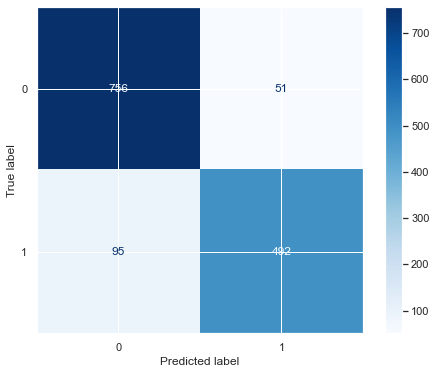

In [113]:
import matplotlib.pyplot as plt  

from sklearn.metrics import plot_confusion_matrix

# plot_confusion_matrix(dt, X_test, y_test,cmap=plt.cm.Blues, values_format='.3f', normalize=('true'))  
plot_confusion_matrix(rf, X_test, y_test, cmap=plt.cm.Blues, values_format='.0f')
plt.show()

In [118]:
recall = recall_score(y_test, y_pred, average='binary')
print('Recall: %.3f' % recall)

Recall: 0.823


#### Tune the Random Forest classifier

In [119]:
from itertools import product
n_estimators = 100
max_features = [1, 'sqrt', 'log2']
max_depths = [None, 2, 3, 4, 5]
for f, d in product(max_features, max_depths): # with product we can iterate through all possible combinations
    rf = RandomForestClassifier(n_estimators=n_estimators, 
                                criterion='entropy', 
                                max_features=f, 
                                max_depth=d, 
                                n_jobs=2,
                                random_state=1337)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X=X_test)
    print('RECALL on TEST set with max_features = {}; max_depth = {} -> {:.3f}'.format(f, d, recall_score(y_test, y_pred, average='binary')))

RECALL on TEST set with max_features = 1; max_depth = None -> 0.821
RECALL on TEST set with max_features = 1; max_depth = 2 -> 0.358
RECALL on TEST set with max_features = 1; max_depth = 3 -> 0.533
RECALL on TEST set with max_features = 1; max_depth = 4 -> 0.651
RECALL on TEST set with max_features = 1; max_depth = 5 -> 0.702
RECALL on TEST set with max_features = sqrt; max_depth = None -> 0.836
RECALL on TEST set with max_features = sqrt; max_depth = 2 -> 0.664
RECALL on TEST set with max_features = sqrt; max_depth = 3 -> 0.716
RECALL on TEST set with max_features = sqrt; max_depth = 4 -> 0.760
RECALL on TEST set with max_features = sqrt; max_depth = 5 -> 0.789
RECALL on TEST set with max_features = log2; max_depth = None -> 0.836
RECALL on TEST set with max_features = log2; max_depth = 2 -> 0.664
RECALL on TEST set with max_features = log2; max_depth = 3 -> 0.716
RECALL on TEST set with max_features = log2; max_depth = 4 -> 0.760
RECALL on TEST set with max_features = log2; max_depth

#### At this point, use the settings with the best RECALL value for the final model... Steps omitted

## 8. XGBoost

Notes:
- XGBoost is short for “eXtreme Gradient Boosting.”
- It is an ensemble model; ensemble models combines different machine learning models into one
- Instead of aggregating predictions, boosters turn weak learners into strong learners by focusing on where the individual models went wrong
- XGBoost trains upon the residuals. Instead of aggregating trees, gradient boosted trees learns from errors during each boosting round



Doc 1: https://xgboost.readthedocs.io/en/latest/parameter.html

Doc 2: https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier

Doc 3: https://towardsdatascience.com/getting-started-with-xgboost-in-scikit-learn-f69f5f470a97

In [120]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost

In [121]:
# classifier = xgboost.XGBClassifier(tree_method='gpu_hist')
classifier = xgboost.XGBClassifier(tree_method='auto')

params={
    "learning_rate":[0.05,0.10,0.15,0.20,0.25,0.30],
    "max_depth":[2,3,4,5,6,8,10,12,15],
    "min_child_weight":[1,3,5,7],
    "gamma":[0.0,0.1,0.2,0.3,0.4],
    "colsample_bytree":[0.3,0.4,0.5,0.7]}

# clf = RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',cv=5,verbose=3)
clf = RandomizedSearchCV(classifier,
                         param_distributions=params,
                         n_iter=5,
                         scoring='recall',
                         cv=5,
                         verbose=3)
# clf = GridSearchCV(classifier,
#                    param_grid=params,
#                    scoring='recall',
#                    cv=5,
#                    verbose=3)
# source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

# fitting it
clf.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] min_child_weight=7, max_depth=4, learning_rate=0.15, gamma=0.2, colsample_bytree=0.7 
[13:34:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_master/src/learner.cc:1039: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  min_child_weight=7, max_depth=4, learning_rate=0.15, gamma=0.2, colsample_bytree=0.7, score=0.818, total=   0.3s
[CV] min_child_weight=7, max_depth=4, learning_rate=0.15, gamma=0.2, colsample_bytree=0.7 
[13:34:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_master/src/learner.cc:1039: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  min_child_weight=7, max_depth=4, learning_rate=0.15, gamma=0.2, colsample_bytree=0.7, score=0.812, total=   0.3s
[CV] min_child_weight=7, max_depth=4, learning_rate=0.15, gamma=0.2, colsample_bytree=0.7 
[13:34:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_master/src/learner.cc:1039: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV]  min_child_weight=7, max_depth=4, learning_rate=0.15, gamma=0.2, colsample_bytree=0.7, score=0.816, total=   0.3s
[CV] min_child_weight=7, max_depth=4, learning_rate=0.15, gamma=0.2, colsample_bytree=0.7 
[13:34:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_master/src/learner.cc:1039: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  min_child_weight=7, max_depth=4, learning_rate=0.15, gamma=0.2, colsample_bytree=0.7, score=0.820, total=   0.3s
[CV] min_child_weight=7, max_depth=4, learning_rate=0.15, gamma=0.2, colsample_bytree=0.7 
[13:34:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_master/src/learner.cc:1039: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to 

[CV]  min_child_weight=3, max_depth=12, learning_rate=0.1, gamma=0.2, colsample_bytree=0.5, score=0.828, total=   0.9s
[CV] min_child_weight=3, max_depth=12, learning_rate=0.1, gamma=0.2, colsample_bytree=0.5 
[13:34:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_master/src/learner.cc:1039: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  min_child_weight=3, max_depth=12, learning_rate=0.1, gamma=0.2, colsample_bytree=0.5, score=0.818, total=   0.8s
[CV] min_child_weight=7, max_depth=10, learning_rate=0.05, gamma=0.4, colsample_bytree=0.5 
[13:34:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_master/src/learner.cc:1039: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   14.9s finished


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           

In [122]:
clf.best_params_

{'min_child_weight': 3,
 'max_depth': 12,
 'learning_rate': 0.1,
 'gamma': 0.0,
 'colsample_bytree': 0.4}

In [123]:
# getting the model with the best parameters
clf.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='auto', validate_parameters=1, verbosity=None)

#### Fitting the model with the best parameters

In [124]:
final_model = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=3, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='auto', validate_parameters=1, verbosity=None)

# fitting it
final_model.fit(X_train,y_train)

y_pred = final_model.predict(X_test)

# Confusion Matrix
# cm = confusion_matrix(y, pred_xgboost)
# cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
# plt.figure()
# plot_confusion_matrix(cm_norm, classes=rf.classes_)


[13:35:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_master/src/learner.cc:1039: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


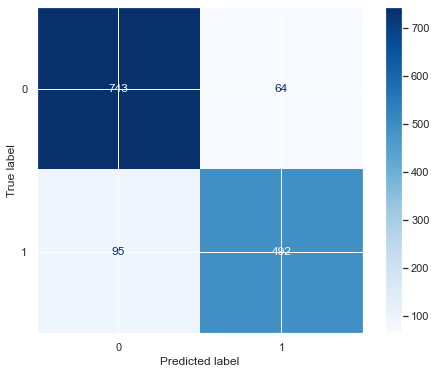

In [125]:
import matplotlib.pyplot as plt  

from sklearn.metrics import plot_confusion_matrix

# plot_confusion_matrix(dt, X_test, y_test,cmap=plt.cm.Blues, values_format='.3f', normalize=('true'))  
plot_confusion_matrix(final_model, X_test, y_test, cmap=plt.cm.Blues, values_format='.0f')
plt.show()

In [126]:
recall = recall_score(y_test, y_pred, average='binary')
print('Recall: %.3f' % recall)

Recall: 0.838


## 9. Deploying our model on NEW, unseen data

In [32]:
# 9.1. Loading the new raw

conn2 = podbc.connect("Driver={SQL Server Native Client 11.0};"
                     "Server=DESKTOP-8L98FK0\MSSQLSERVER09;"
                     "Database=Data360YP;"
                     "Trusted_Connection=yes;")

# rynning the SQL quey i need
unseen_data = pd.read_sql_query('''SELECT * FROM [dbo].[new_unseen_data]''', conn2)

#conn.close()

# print the shape
print(unseen_data.shape)

# Viz
unseen_data.head()

(3344, 13)


,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary
0,1,15634638,AP Hargrave,619,France,Female,42,2,0,1,1,1,101348.88
1,2,15647347,AP Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,3,15619340,AP Onio,502,France,Female,42,8,159660.8,3,1,0,113931.57
3,4,15701390,AP Boni,699,France,Female,39,1,0,2,0,0,93826.63
4,5,15737924,AP Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [130]:
# Loading from CSV
unseen_data = pd.read_csv('new unseen data.csv', encoding='latin-1')

In [133]:
unseen_data.tail()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
3339,3340,15631341,AP Franklin,599,Spain,Female,28,4,126833.79,2,1,0,60843.09,1
3340,3341,15809299,AP Y?,729,Germany,Male,29,5,109676.52,1,1,1,25548.47,0
3341,3342,15640902,AP Peng,718,France,Female,29,3,0.00,1,0,1,134462.29,0
3342,3343,15775699,AP Otitodilichukwu,712,Germany,Male,53,6,134729.99,2,1,1,132702.64,0
3343,3344,15631836,AP Pagnotto,474,France,Male,37,3,98431.37,1,0,0,75698.44,0


In [136]:
# 9.2. Applying the same pre-processing stages

# Limiting the data
unseen_data2 = unseen_data[['CreditScore', 'Geography',
                            'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
                            'IsActiveMember', 'EstimatedSalary', 'Exited']]

# dummy variables
unseen_data2 = pd.get_dummies(unseen_data2, columns = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember'])

#scaling
# scale_vars = ['creditscore','estimatedsalary','balance','age']
# unseen_data2[scale_vars] = scaler.fit_transform(unseen_data2[scale_vars])


unseen_data2.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1
0,619,42,2,0.00,1,101348.88,1,1,0,0,1,0,0,1,0,1
1,608,41,1,83807.86,1,112542.58,0,0,0,1,1,0,1,0,0,1
2,502,42,8,159660.80,3,113931.57,1,1,0,0,1,0,0,1,1,0
3,699,39,1,0.00,2,93826.63,0,1,0,0,1,0,1,0,1,0
4,850,43,2,125510.82,1,79084.10,0,0,0,1,1,0,0,1,0,1


#### Check for imbalance in the dataset

In [138]:
# Determine the percentage of customers who churned ('Exited' field)

# raw_data['Exited'].value_counts()`
unseen_data2['Exited'].value_counts(normalize=True) * 100

0    78.797847
1    21.202153
Name: Exited, dtype: float64

In [139]:
# 9.3. Making predictions

pred_xgboost = final_model.predict(unseen_data2.drop('Exited', axis=1))
pred_xgboost

array([1, 0, 1, ..., 0, 0, 0], dtype=int64)

In [140]:
y_test = unseen_data2['Exited']
y_pred = pred_xgboost
recall = recall_score(y_test, y_pred, average='binary')
print('Recall: %.3f' % recall)

Recall: 0.873


In [37]:
# 9.4. Joining the raw data witht the predictions

output = unseen_data.copy()
output['Predictions - Churn or Not'] = pred_xgboost
output['Predictions - Probability to Churn'] = column(pred_prob_xgboost, 1)
output['Predictions - Churn or Not Desc'] = 'Empty'
output['Predictions - Churn or Not Desc'][output['Predictions - Churn or Not'] == 0] = 'Retention'
output['Predictions - Churn or Not Desc'][output['Predictions - Churn or Not'] == 1] = 'Churn'
output.head()

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,Predictions - Churn or Not,Predictions - Probability to Churn,Predictions - Churn or Not Desc
0,1,15634638,AP Hargrave,619,France,Female,42,2,0,1,1,1,101348.88,0,0.330071,Retention
1,2,15647347,AP Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0.193652,Retention
2,3,15619340,AP Onio,502,France,Female,42,8,159660.8,3,1,0,113931.57,1,0.944657,Churn
3,4,15701390,AP Boni,699,France,Female,39,1,0,2,0,0,93826.63,0,0.065576,Retention
4,5,15737924,AP Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0.097383,Retention


In [38]:
# 9.5. Exporting this data back to a New Table in SQL
from sqlalchemy import create_engine
import urllib

quoted = urllib.parse.quote_plus("Driver={SQL Server Native Client 11.0};"
                     "Server=DESKTOP-8L98FK0\MSSQLSERVER09;"
                     "Database=Data360YP;"
                     "Trusted_Connection=yes;")

engine = create_engine('mssql+pyodbc:///?odbc_connect={}'.format(quoted))

output.to_sql('Churn Predictions Output', schema='dbo', con = engine, if_exists = 'replace')

In [39]:
# 9.5. Exporting the data in a CSV
output.to_csv('Churn Predictions Output', sep='\t')

os.getcwd() 

'C:\\Users\\pitsi\\Desktop\\Python Tutorials\\Decision Trees'